<a href="https://colab.research.google.com/github/Chloe797/AutoCEFR/blob/main/Copy_of_Step_4_BERT_mutli_label_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BERT Multi Label Text Classification**

Step 4 of this project will use a BERT Transformer Architecture for this task. The BERT model will be trained using the training data for multi label text classification. It will then be used to predict the CEFR level of each text from the test data.

In [ ]:
#installing needed packages
!pip install datasets
!pip install evaluate
!pip install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
#importing libraries needed for task
import numpy as np
from datasets import load_dataset, Dataset
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import Trainer
from transformers import TrainingArguments
import evaluate
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# loading local files into Dataset format
raw_datasets = load_dataset("csv", data_files= {"train": "Training Data - EN - Sheet1.csv", "test": "Test Data - EN - Sheet1.csv" })

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
#to determine train, val, test lengths
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1728
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 101
    })
})


In [ ]:
raw_datasets.keys() # will split the train to create validation set

dict_keys(['train', 'test'])

As it is a small dataset, we will create a validation size of 500 samples. Therefore the training will be on 1228 samples and the test is 101 samples.

In [ ]:
#Creating train, validation and test splits, validation coming from training
train_dataset = raw_datasets['train'].shuffle(seed=42).select(range(1228))
val_dataset = raw_datasets['train'].shuffle(seed=42).select(range(1228, 1728)) # 500
test_dataset = raw_datasets['test'].shuffle(seed=42)


print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1228
500
101


Unlike examples from load dataset such as 'imdb', text labels have not yet been converted from string to integers.
Datasets 'map' function was used to convert.
[Dataset Map features further info.](https://huggingface.co/docs/datasets/v3.2.0/process)

Could alternatively use pandas to create dataframes and apply .map() function but it was decided to keep as close to example given as possible.

In [ ]:
#Creating function to convert string label to integer and keep in Dataset format
def label_mapping(item): # simple mapping function
  mapping_labels = {
      'A1' : 0,
      'A2': 1,
      'B1': 2,
      'B2': 3,
      'C1': 4,
      'C2': 5
      }
  item['label'] = mapping_labels[item['label']]
  return item

train_dataset = train_dataset.map(label_mapping)
val_dataset = val_dataset.map(label_mapping)
test_dataset = test_dataset.map(label_mapping)

Map:   0%|          | 0/1228 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

In [ ]:
#checking one sample to see that label hass been applied correctly
train_dataset[0]

{'text': '\ufeffThe last time she took to the stage, the prototype of the mobile phone was undergoing its first trials. Thirty-five years later, as she performs once again, singer Kate Bush is faced with a different world. \nWhile most concerts are now aglow with phones and tablets, Bush is taking a stand against fans watching her shows through the digital veil of a screen. \nPrior to her highly anticipated series of concerts at the Hammersmith Apollo in London, Bush released a statement appealing to her fans to put down their mobile phones at her gigs. \nBush wrote on her website: “I have a request for all of you who are coming to the shows. We have purposefully chosen an intimate theatre setting rather than a large venue or stadium. It would mean a great deal to me if you would please refrain from taking photos or filming during the shows. \n“I very much want to have contact with you as an audience, not with iPhones, iPads or cameras. I know it’s a lot to ask but it would allow us to

Bert Based Cased is the mdoel chosen for this task. It was trained on English language data, such as unpublished books and English Wikipedia, meaning it is unlikely to be trained on any of this data. [BERT Information Hugging Face](https://huggingface.co/google-bert/bert-base-cased)


In [ ]:
#load Bert pretrained model and set labels to 6 (i.e. A1, A2, B1, B2, C1, C2)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=6)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#loading tokenizer to process text
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") # same as model used for classification

#tokenizing and processing the data, making all samples a uniform length either by cutting the length (i.e. truncating) or padding
def tokenize_dataset(dataset, tokenizer):
  tokenized_dataset = []
  for item in dataset:
    tokenized = tokenizer(item["text"], padding="max_length", truncation=True, max_length=512) #512 is max for token/sub tokens allowed in sequence.
    item.update(tokenized)
    tokenized_dataset.append(item)
  return tokenized_dataset

tokenized_train = tokenize_dataset(train_dataset, tokenizer)
tokenized_val = tokenize_dataset(val_dataset, tokenizer)
tokenized_test = tokenize_dataset(test_dataset, tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
#Checking tokenized items
print(tokenized_train[:1])

[{'text': '\ufeffThe last time she took to the stage, the prototype of the mobile phone was undergoing its first trials. Thirty-five years later, as she performs once again, singer Kate Bush is faced with a different world. \nWhile most concerts are now aglow with phones and tablets, Bush is taking a stand against fans watching her shows through the digital veil of a screen. \nPrior to her highly anticipated series of concerts at the Hammersmith Apollo in London, Bush released a statement appealing to her fans to put down their mobile phones at her gigs. \nBush wrote on her website: “I have a request for all of you who are coming to the shows. We have purposefully chosen an intimate theatre setting rather than a large venue or stadium. It would mean a great deal to me if you would please refrain from taking photos or filming during the shows. \n“I very much want to have contact with you as an audience, not with iPhones, iPads or cameras. I know it’s a lot to ask but it would allow us t

More Information on [Training](https://huggingface.co/docs/transformers/en/main_classes/trainer#api-reference%20][%20transformers.Trainer) [Arguments](https://huggingface.co/docs/transformers/v4.47.1/en/main_classes/trainer#transformers.TrainingArguments)

Evaluation strategy = ''Epoch'' means evaluation is done at the end of each epoch.

In [ ]:
#setting the training arguments to be used in the trainer
training_args = TrainingArguments("test_trainer",num_train_epochs=5, eval_strategy="epoch", report_to="none")

load_metric has been replaced in newest verion with evaluate.
[More Information here](https://discuss.huggingface.co/t/cant-import-load-metric-from-datasets/107524/4)

In [ ]:
#importing accuracy metric as chosen metric to evaluate performance
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1) # logits are the raw probabilities

  return metric.compute(predictions=predictions, references=labels)


In [ ]:
#loading trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

In [ ]:
#training the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.298045,0.624000
2,No log,1.448161,0.602000
3,No log,1.841650,0.628000
4,0.311100,2.091023,0.636000
5,0.311100,2.176443,0.632000


TrainOutput(global_step=770, training_loss=0.21615853743119673, metrics={'train_runtime': 838.5604, 'train_samples_per_second': 7.322, 'train_steps_per_second': 0.918, 'total_flos': 1615559899668480.0, 'train_loss': 0.21615853743119673, 'epoch': 5.0})

## Training Accuracy

The trainer was run twice.

First Run

```
Epoch	Training Loss	Validation Loss	Accuracy
1	      No log	        1.034998	    0.540000
2	      No log	        0.995145	    0.578000
3	      No log	        0.929605	    0.604000
4	      1.058500	      1.043769	    0.594000
5	      1.058500	      1.049214	    0.618000


TrainOutput(global_step=770, training_loss=0.8305569636357295, metrics={'train_runtime': 688.9308, 'train_samples_per_second': 8.912, 'train_steps_per_second': 1.118, 'total_flos': 1615559899668480.0, 'train_loss': 0.8305569636357295, 'epoch': 5.0})

```
Second Run

```
Epoch	Training Loss	Validation Loss	Accuracy
1     	No log	     1.298045	      0.624000
2	      No log	     1.448161	      0.602000
3	      No log	     1.841650	      0.628000
4	      0.311100	   2.091023	      0.636000
5	      0.311100	   2.176443	      0.632000


TrainOutput(global_step=770, training_loss=0.21615853743119673, metrics={'train_runtime': 838.5604, 'train_samples_per_second': 7.322, 'train_steps_per_second': 0.918, 'total_flos': 1615559899668480.0, 'train_loss': 0.21615853743119673, 'epoch': 5.0})
```




In [ ]:
#testing and evaluating on test data
trainer.evaluate(tokenized_test)

{'eval_loss': 3.28019642829895,
 'eval_accuracy': 0.4752475247524752,
 'eval_runtime': 2.8443,
 'eval_samples_per_second': 35.51,
 'eval_steps_per_second': 4.571,
 'epoch': 5.0}

## Test Data Accuracy

First Run

```
{'eval_loss': 1.86720609664917,
 'eval_accuracy': 0.44554455445544555,
 'eval_runtime': 2.9075,
 'eval_samples_per_second': 34.738,
 'eval_steps_per_second': 4.471,
 'epoch': 5.0}
```

Second Run

```
{'eval_loss': 3.28019642829895,
 'eval_accuracy': 0.4752475247524752,
 'eval_runtime': 2.8443,
 'eval_samples_per_second': 35.51,
 'eval_steps_per_second': 4.571,
 'epoch': 5.0}
```



In [ ]:
#getting predictions
predictions = trainer.predict(tokenized_test)

In [ ]:
#creating true labels for confusion matrix
gold_labels = []
for item in test_dataset:
  gold_labels.append(item['label'])

In [ ]:
gold_labels[:10]

[3, 1, 3, 1, 2, 2, 2, 1, 5, 3]

In [ ]:
#choosing one label for each test sample
predictions = np.argmax(predictions.predictions, axis=-1)

In [ ]:
predictions[:10]
predicted_labels = predictions.tolist()

In [ ]:
predicted_labels[:10]

[2, 1, 0, 1, 1, 3, 0, 1, 4, 3]

In [ ]:
#classification reports
class_report = classification_report(gold_labels, predicted_labels)
print(class_report)

              precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.59      0.62      0.61        16
           2       0.45      0.41      0.43        22
           3       0.39      0.43      0.41        21
           4       0.48      0.59      0.53        17
           5       0.14      0.08      0.11        12

    accuracy                           0.48       101
   macro avg       0.46      0.47      0.46       101
weighted avg       0.46      0.48      0.46       101



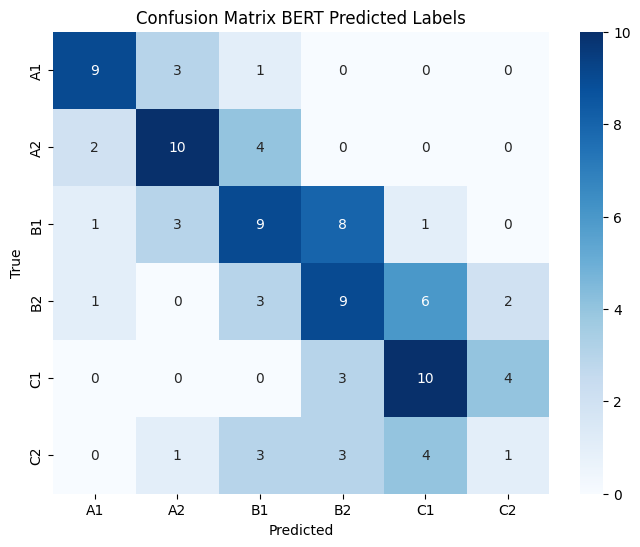

In [ ]:
#Confusion matrix
conf_matrix = confusion_matrix(gold_labels, predicted_labels)
# Plot the confusion matrix
xticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
yticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix BERT Predicted Labels')
plt.show()

### Notes

We can see that BERT achieved an accuracy of 48% with the main missclassifications happening at the C2 Level.


